## Logistic Regression - Titanic

The titanic dataset is a popular dummy dataset used to learn about logistic regression. It has also been used in a [Kaggle data science competition](https://www.kaggle.com/c/titanic), so you'll also find blogposts exploring all kinds of more advanced concepts that use this dataset too! In this assignment, you'll do a logistic regression to look at the effect of sex and class on survival on the titanic, by computing odds ratios.

adapted from: https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-homework.ipynb

Some references:

- [What are odds vs. probability?](https://towcenter.gitbooks.io/curious-journalist-s-guide-to-data/content/analysis/counting_possible_worlds.html)
- [Investigate.ai on Logistic Regressions](https://investigate.ai/regression/logistic-regression-quickstart/)
- [StatQuest Logistic Regressions Playlist](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)
- [How do I interpret odds ratios in logistic regression?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) This one's a little more technical, but has good examples.


In [1]:
import pandas as pd
import numpy as np 
from plotnine import *

/Users/ilenapeng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Load the data

Read in the `titanic.csv` data set again.

In [2]:
# Load titanic.csv
df = pd.read_csv('titanic.csv')
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender
0,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male
3,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male
...,...,...,...,...,...,...,...,...,...,...
1308,3rd,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male
1309,3rd,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male
1310,3rd,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male
1311,3rd,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female


The first thing we need to do is code the pclass and gender variables numerically. Let's use the following scheme:
- pclass: 1,2,3
- gender: 0=male, 1=female, and let's call the column called "female" to remind us which is which

In [3]:
# recode the pclass and gender variables so they are numeric
# this contains the implication that the difference between 1st and 2nd is the same as between 2nd and 3rd
# solution: you could treat them as three separate dummy variables, because then that would be considering them as
# separate entities, like blue, green and yellow
df['pclass'] = df.pclass.replace({'1st': 1, '2nd': 2, '3rd': 3})
df['female'] = df.gender.replace({'male': 0, 'female': 1})
df.head(3)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0


### 1. Exploratory data analysis

In [4]:
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0


In [5]:
# First, let's do some descriptive stats
# 
# How many men and women are travelling on the titanic?
# How many people are travelling in each class?
# What share of each survived?
piv = df.pivot_table(index='survived', columns='female', aggfunc='count', values='name')
display(piv)

pct_survived = piv.apply(lambda x: x/sum(x)).round(2)
display(pct_survived)

female,0,1
survived,,
0,708,156
1,142,307


female,0,1
survived,,
0,0.83,0.34
1,0.17,0.66


In [6]:
# odds ratio here would be
(142/708)*9.8 
# means something, but idk what

1.965536723163842

### 2. Logistic regression with one variable at a time

First, do a logistic regression of the `female` variable alone to predict the probability of survival. Below is some code that will help you plot the result.

In [7]:
# Step 1: Run a logistic regression on one variable and see the summary of the output

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

import statsmodels.formula.api as smf

model = smf.logit("survived ~ female", data=df)
results = model.fit()
results.summary()

# Female coeff is positive, so we know that going from 0 to 1 (male > female) INCREASES your odds of survival

Optimization terminated successfully.
         Current function value: 0.517411
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.1945
Time:                        15:01:59   Log-Likelihood:                -679.36
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.572e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6066      0.092    -17.473      0.000      -1.787      -1.426
female         2.2836      0.135     16.963      0.000       2.020       2.547
==============================================================================
"""

In [8]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['prediction'] = results.predict(df['female'])
df.head()

# The numbers in the "prediction" tell us what % each person has of survival based on their gender 
# These numbers are the same as our pivot table, because we're only looking at one variable

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059


In [9]:
# Step 3: What is the odds ratio of on the gender variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

# If you are a woman, your ODDS of survival are 9.8 times higher

,coef,odds ratio,pvalue,name
Intercept,-1.606617,0.200565,2.306853e-68,Intercept
female,2.283609,9.812026,1.529597e-64,female


Now, try the same thing but with the `pclass` variable

In [10]:
# Step 1: Run a logistic regression on one variable and see the summary of the output

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression
# y ~ x
model = smf.logit("survived ~ pclass", data=df)
results = model.fit()
results.summary()

# Negative coeff for pclass means 1-2 or 2-3rd class DECREASES your odds of survival

Optimization terminated successfully.
         Current function value: 0.576759
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.1021
Time:                        15:01:59   Log-Likelihood:                -757.28
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.459e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3996      0.170      8.236      0.000       1.067       1.733
pclass        -0.9285      0.074    -12.611      0.000      -1.073      -0.784
==============================================================================
"""

In [11]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['prediction'] = results.predict(df['pclass'])
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.615642
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.615642
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.615642
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.615642
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.615642


In [12]:
# Step 3: What is the odds ratio of on the pclass variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

# For every class increase (first to second or two to third), the likelihood of survival is 0.39 times higher

,coef,odds ratio,pvalue,name
Intercept,1.399625,4.053680,1.778696e-16,Intercept
pclass,-0.928532,0.395133,1.832570e-36,pclass


In [13]:
# For running both female and pclass "The effect of being female in positive direction has a greater impact than class bringing in 
# negative direction"
# If you're trying to compare x1 to x2, compar the coeff. But if you just want x1, just use the odds ratio.

**Bonus** 🤖 - Writing clean/DRY code

DRY stands for "Don't Repeat Yourself". This is a good principle of writing clean code. Instead of copy/pasting code multiple times (which can lead to errors if you fix one copy but not the other), you can write DRY code by wrapping any chunk of code you plan to repeat in a function. As a bonus on this section, re-write the code above as a function and run that function once on `female` and once on `pclass`.

### 3. Looking at two variables at a time

We know from the earlier assignment that class also affects survival, so let's add that to our model. Compute a logistic regression on the variables `pclass` and `female`.

In [23]:
# Logistic regression on two variables

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

model = smf.logit("survived ~ female + pclass", data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.457739
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.2874
Time:                        15:05:53   Log-Likelihood:                -601.01
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                5.504e-106
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6210      0.196      3.173      0.002       0.237       1.005
female         2.4285      0.151     16.117      0.000       2.133       2.724
pclass        -1.0373      0.088    -11.787      0.000      -1.210      -0.865
==============================================================================
"""

In [24]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['prediction'] = results.predict()
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.882065
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.397390
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.397390


In [ ]:
# Step 3: What is the odds ratio of on the gender variable?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

### 4. What does this mean

What is the odds ratio on the `pclass` variable? What happens to the odds of survival when we move from 1st to 2nd or from 2nd to 3rd class?


In [ ]:
👉

### 5. Bonus - Age

Does the age of a passenger impact their chances of survival?

<AxesSubplot:>

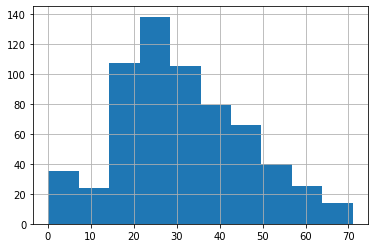

In [18]:
df.age.hist()

In [25]:
# drop missing ages
df_age = df.dropna(subset=['age'])

In [44]:
# model with just age
model = smf.logit("survived ~ age", data=df_age)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.683624
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      631
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                0.004687
Time:                        15:13:06   Log-Likelihood:                -432.73
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                   0.04351
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1172      0.188      0.624      0.532      -0.251       0.485
age           -0.0110      0.005     -2.008      0.045      -0.022      -0.000
==============================================================================
"""

In [45]:
df_age['prediction'] = results.predict(df_age['age'])
df_age.head()

/var/folders/9x/ttxn_gwj0592mr6h8s5y29980000gn/T/ipykernel_30455/2646301280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.449509
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.523766
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.446782
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.460449
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.526746


<AxesSubplot:xlabel='age', ylabel='prediction'>

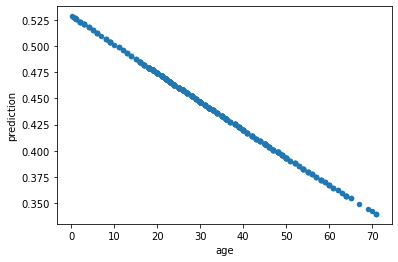

In [46]:
# scatterplot: age vs prediction
df_age.plot.scatter(x='age',  y='prediction')

In [37]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

,coef,odds ratio,pvalue,name
Intercept,0.117195,1.124339,0.532483,Intercept
age,-0.011029,0.989031,0.044647,age


In [38]:
# model with female and age

model = smf.logit("survived ~ age + female", data=df_age)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.495613
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      630
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.2784
Time:                        15:09:30   Log-Likelihood:                -313.72
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 2.687e-53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9257      0.241     -3.847      0.000      -1.397      -0.454
age           -0.0129      0.007     -1.882      0.060      -0.026       0.001
female         2.8415      0.209     13.592      0.000       2.432       3.251
==============================================================================
"""

In [39]:
df_age['prediction'] = results.predict()
df_age.head()

/var/folders/9x/ttxn_gwj0592mr6h8s5y29980000gn/T/ipykernel_30455/1407821511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.823631
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.868756
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.211938
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.831014
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.281406


In [40]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

,coef,odds ratio,pvalue,name
Intercept,-0.925653,0.396272,1.197322e-04,Intercept
age,-0.012921,0.987162,5.977245e-02,age
female,2.841503,17.141511,4.494739e-42,female


In [41]:
# model with age and class

model = smf.logit("survived ~ age + pclass", data=df_age)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.606641
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      630
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.1168
Time:                        15:11:38   Log-Likelihood:                -384.00
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 8.948e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3253      0.415      8.008      0.000       2.511       4.139
age           -0.0411      0.007     -5.972      0.000      -0.055      -0.028
pclass        -1.1825      0.131     -9.019      0.000      -1.439      -0.925
==============================================================================
"""

In [42]:
df_age['prediction'] = results.predict()
df_age.head()

/var/folders/9x/ttxn_gwj0592mr6h8s5y29980000gn/T/ipykernel_30455/1407821511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.721158
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.887015
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.712813
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.753007
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.891404


In [43]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

,coef,odds ratio,pvalue,name
Intercept,3.325310,27.807609,1.167244e-15,Intercept
age,-0.041126,0.959708,2.346126e-09,age
pclass,-1.182451,0.306527,1.903405e-19,pclass


In [47]:
# THE EVERYTHING MODEL

model = smf.logit("survived ~ age + pclass + female", data=df_age)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.426398
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.3792
Time:                        15:15:05   Log-Likelihood:                -269.91
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 3.662e-71
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8188      0.502      5.620      0.000       1.836       3.802
age           -0.0489      0.009     -5.673      0.000      -0.066      -0.032
pclass        -1.4224      0.170     -8.387      0.000      -1.755      -1.090
female         3.0862      0.241     12.790      0.000       2.613       3.559
==============================================================================
"""

In [48]:
df_age['prediction'] = results.predict()
df_age.head()

/var/folders/9x/ttxn_gwj0592mr6h8s5y29980000gn/T/ipykernel_30455/1407821511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.955445
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.987689
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.482606
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.963063
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.794392


In [49]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

,coef,odds ratio,pvalue,name
Intercept,2.818805,16.756822,1.907179e-08,Intercept
age,-0.048867,0.952308,1.403173e-08,age
pclass,-1.422401,0.241134,4.998668e-17,pclass
female,3.086188,21.893452,1.860397e-37,female


In [ ]:
# WHAT WE SHOULD PROBABLY DO LATer: BUCKETED AGES